In [1]:
#1st part -(scaling down images and saving in jpg fomat)

In [2]:
import openslide
from openslide import OpenSlide
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [3]:
print(openslide.__library_version__)

3.4.1


In [4]:
from matplotlib import pyplot as plt
from wsipre import slide, show

In [5]:
#opens a wsi
wsi = slide.Slide(filename='CMU-1.tiff')

In [6]:
#prints total number of levels in a wsi
print(wsi.level_count)

9


In [7]:
#prints level dimensions
print(wsi.level_dimensions)

((46000, 32914), (23000, 16457), (11500, 8228), (5750, 4114), (2875, 2057), (1437, 1028), (718, 514), (359, 257), (179, 128))


In [8]:
#get the dimensions of the wsi at level 0
wsi_size=wsi.level_dimensions[0]
wsi_width=wsi_size[0]
wsi_height=wsi_size[1]
print("wsi width = ",wsi_width)
print("wsi height = ",wsi_height)

wsi width =  46000
wsi height =  32914


In [9]:
#select a downscaling factor
#here, I used 16 because the wsi was already small
downscaling_factor=32

In [10]:
#scaling down width and height
import numpy as np
down_scaled_width=int(wsi_width/downscaling_factor)
down_scaled_height=int(wsi_height/downscaling_factor)
print("Down scaled width = ",down_scaled_width)
print("Down scaled height = ",down_scaled_height)

Down scaled width =  1437
Down scaled height =  1028


In [11]:
#displays a scaled down pillow format image of the wsi
thumbnail=wsi.get_thumbnail((down_scaled_width,down_scaled_height))

In [12]:
#displays the scaled down wsi size
print(thumbnail.size)

(1437, 1028)


image size =  (1437, 1028)


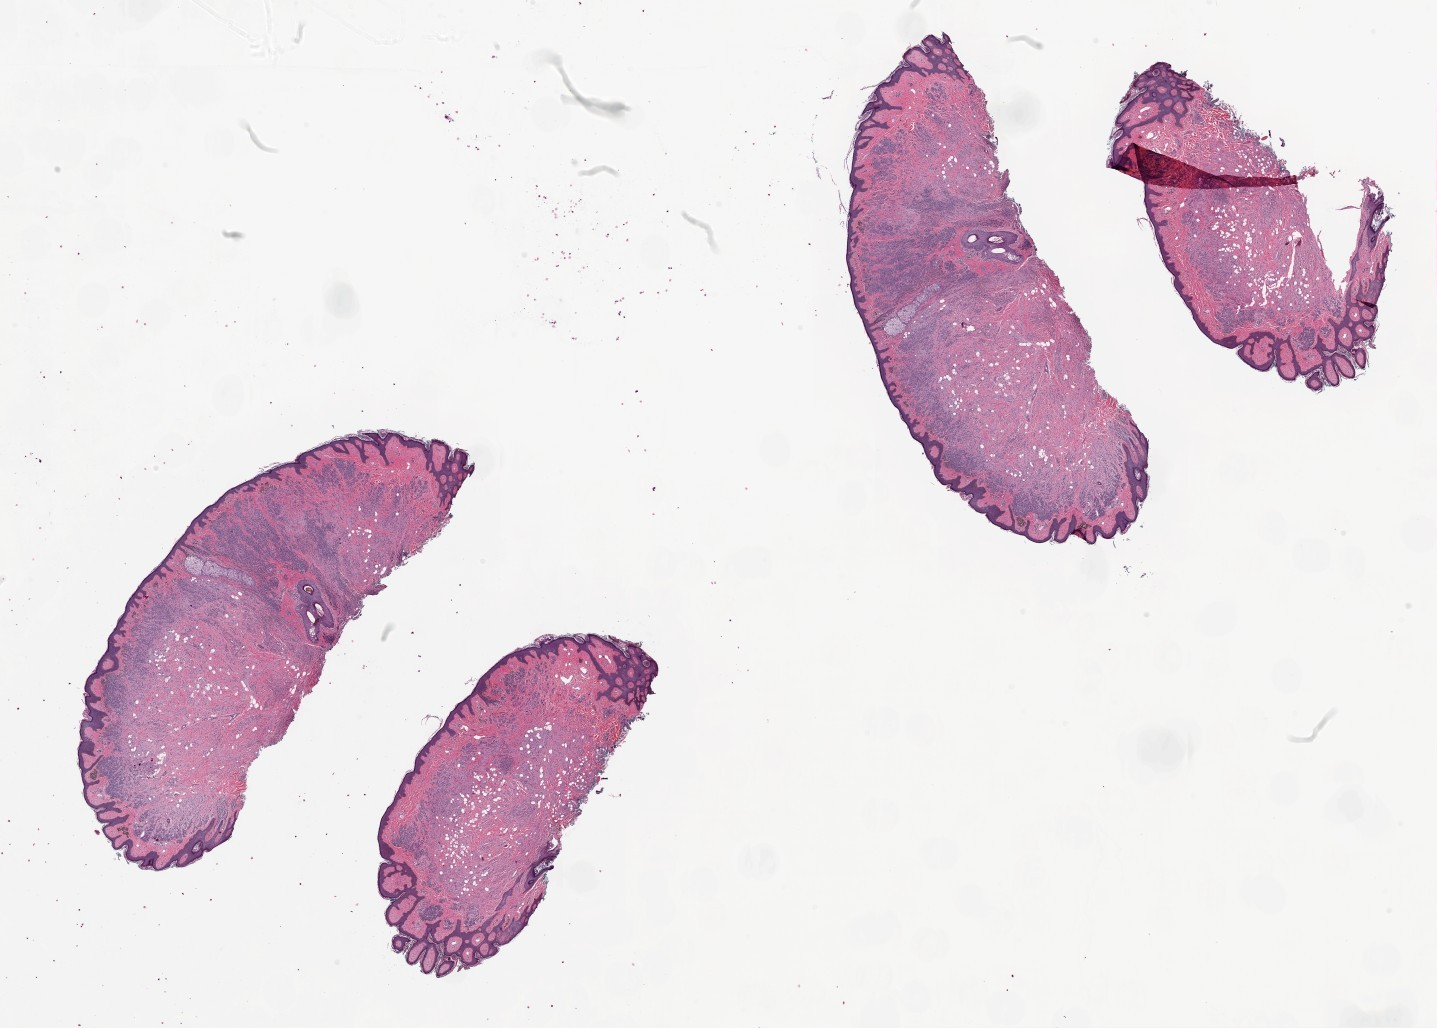

In [13]:
#saves pillow image to jpg format
rgb_im = thumbnail.convert('RGB')
rgb_im.save('scaled_down.jpg')
print("image size = ",rgb_im.size)
rgb_im

(1028, 1437, 3)


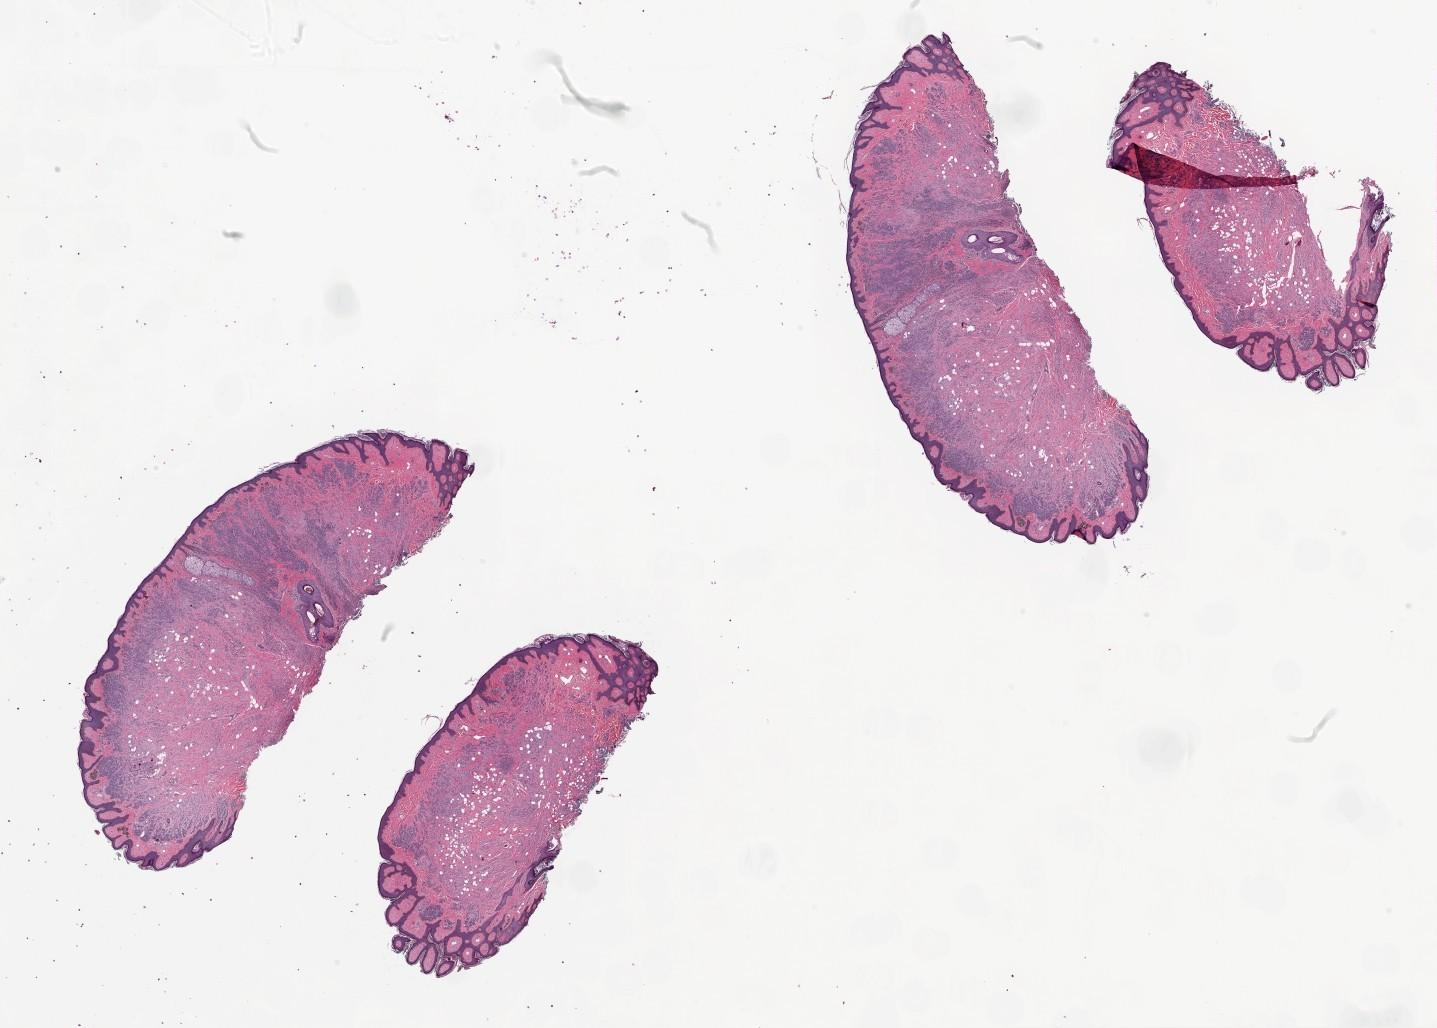

In [14]:
#load the saved downscaled image using opencv
import cv2
image = cv2.imread('scaled_down.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(img.shape)
display(Image.fromarray(img))

In [15]:
#end of part 1

In [16]:
#2nd part - (applying filters)

(1028, 1437)


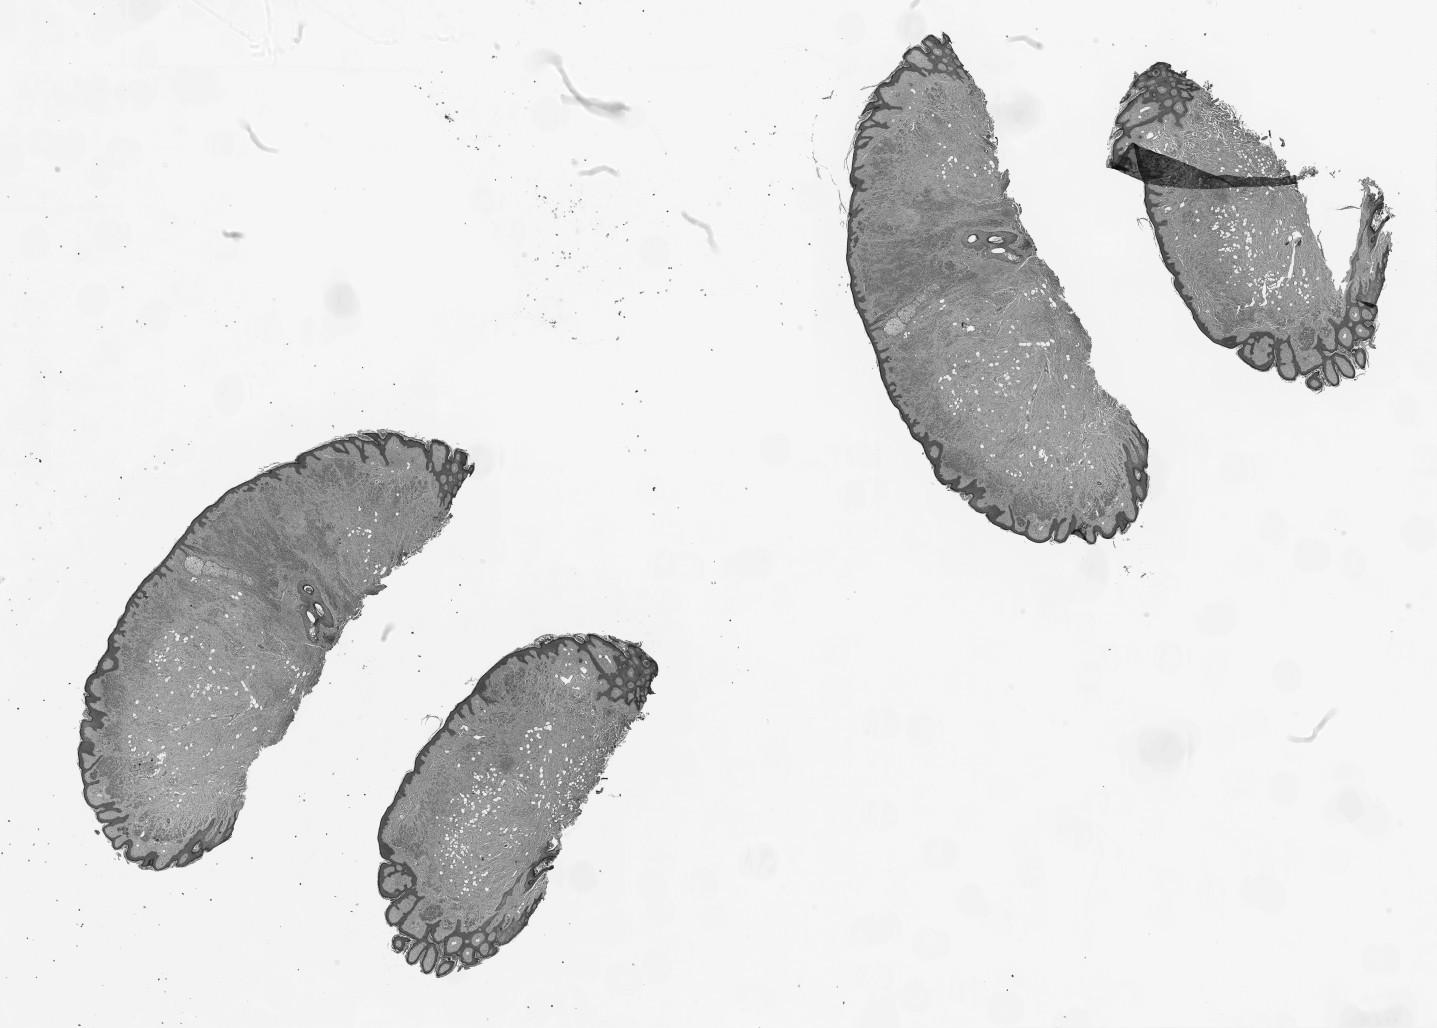

In [17]:
#converting rgb image to grayscale image
def grayscale(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    display(Image.fromarray(gray))
    return gray
grayscale_image=grayscale(img)

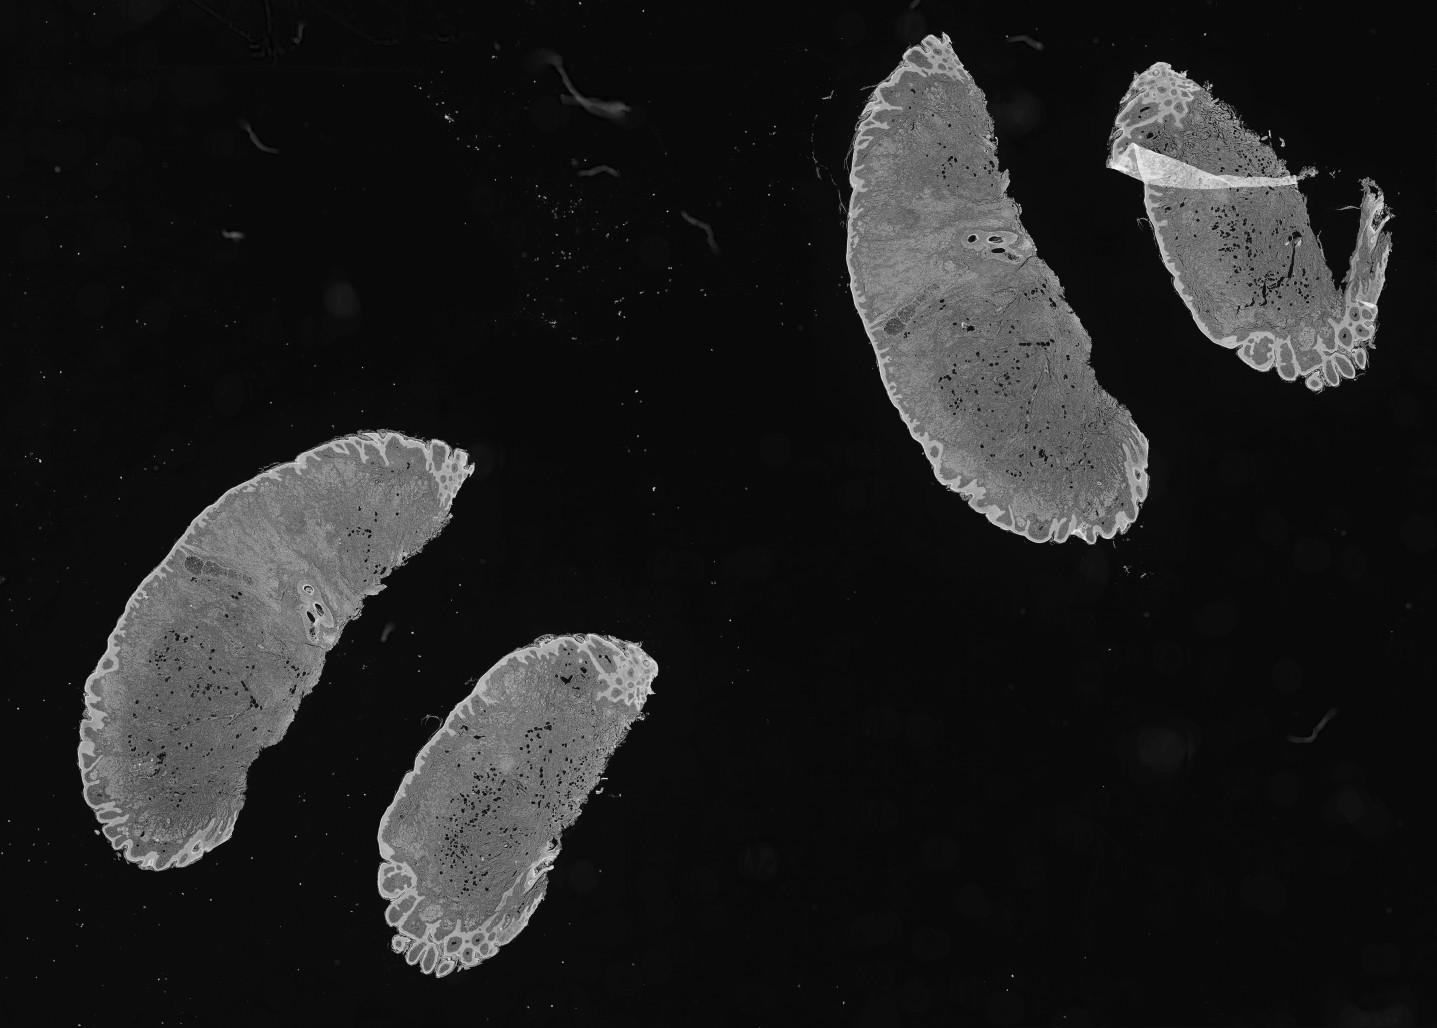

In [18]:
#invert the grayscale image
def invert_grayscale(image):
    invert_grayscale = cv2.bitwise_not(image)
    display(Image.fromarray(invert_grayscale))
    return(invert_grayscale)
inverted_image=invert_grayscale(grayscale_image)

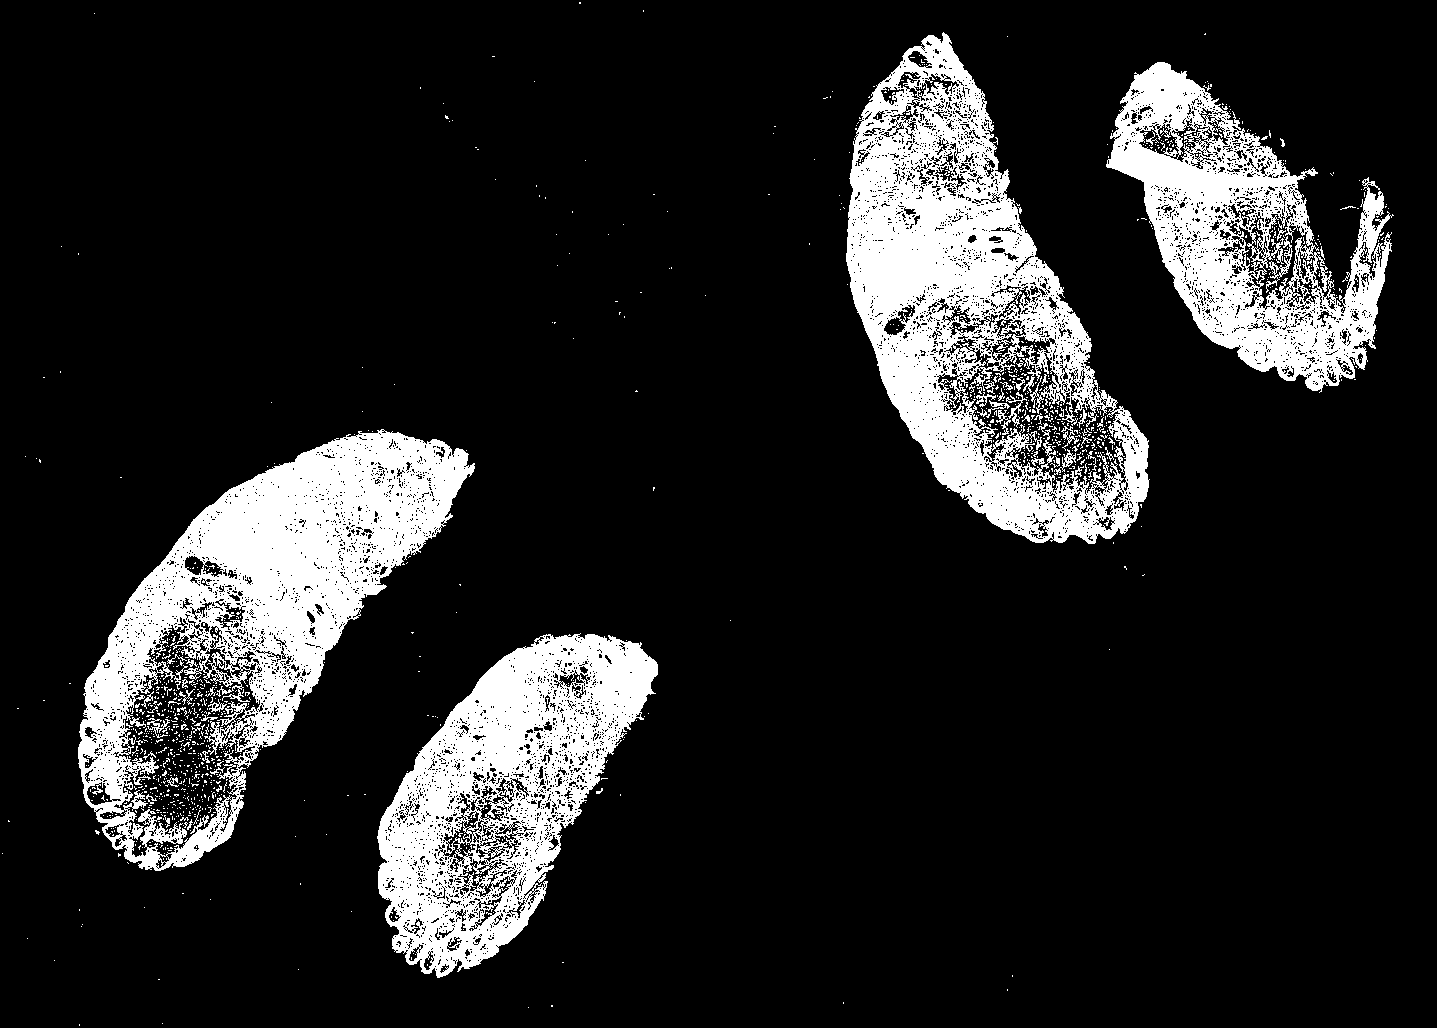

In [30]:
#basic thresholding on inverted grayscale image -(pixels with value less than 100 are set to zero)
def basic_threshold(image,orig):
    ret,basic_threshold= cv2.threshold(image,100,255,cv2.THRESH_BINARY)
    display(Image.fromarray(basic_threshold))
    return basic_threshold
basic_thresholded_mask=basic_threshold(inverted_image,img)

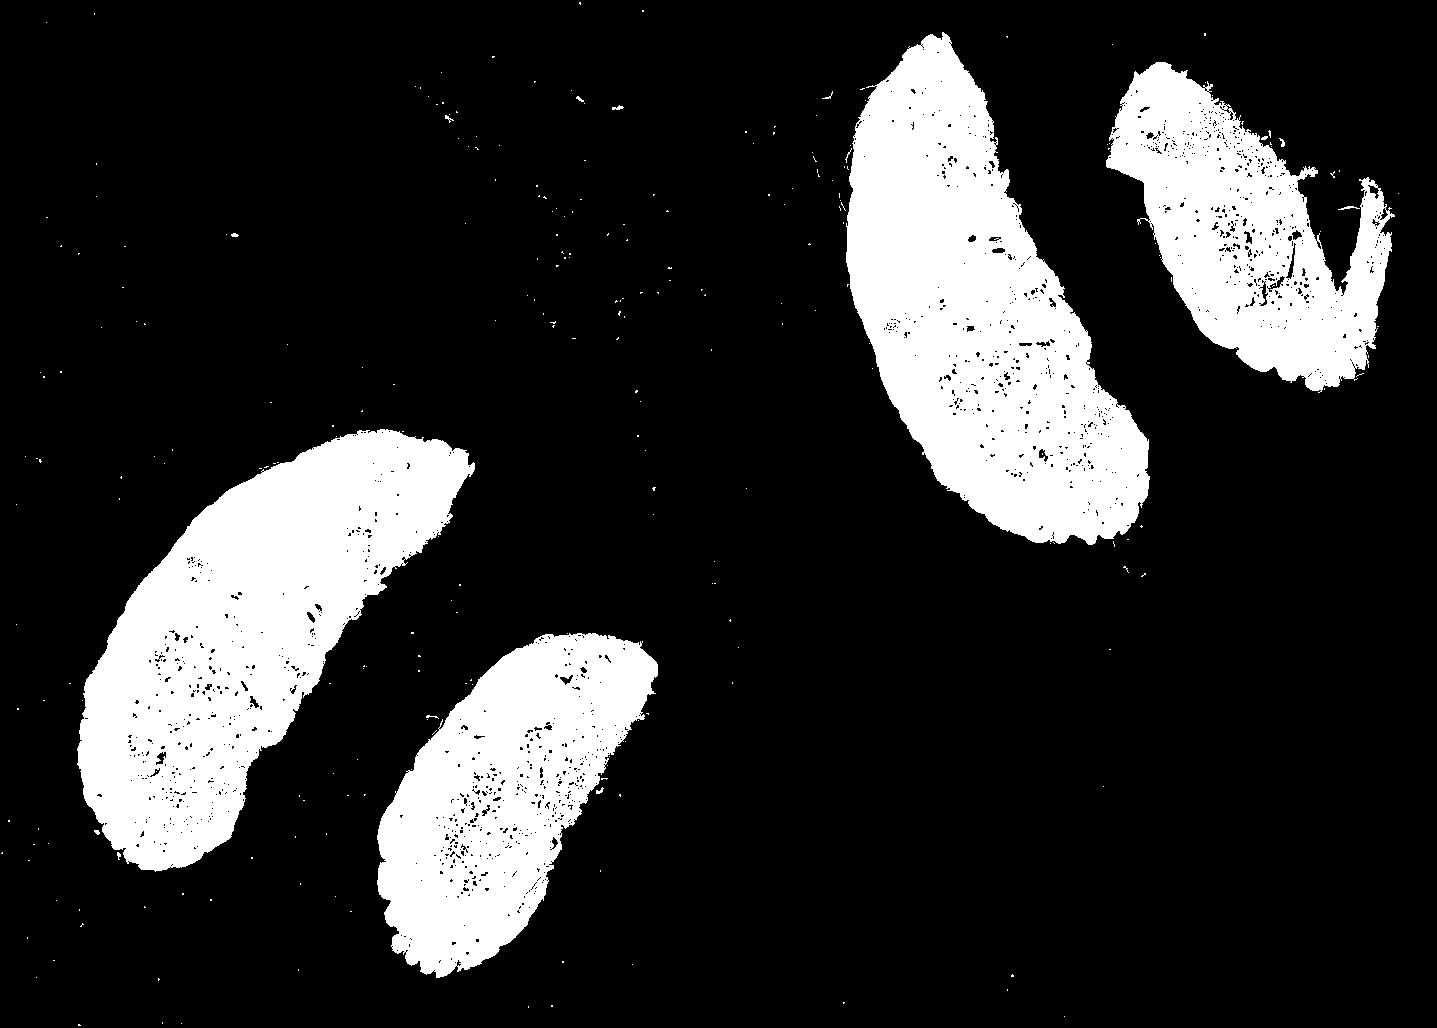

In [20]:
#Otsu's thresholding on inverted grayscale image
def otsu_threshold(image):
    ret2,otsu_threshold = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    display(Image.fromarray(otsu_threshold))
    return(otsu_threshold)
otsu_thresholded_image=otsu_threshold(inverted_image)

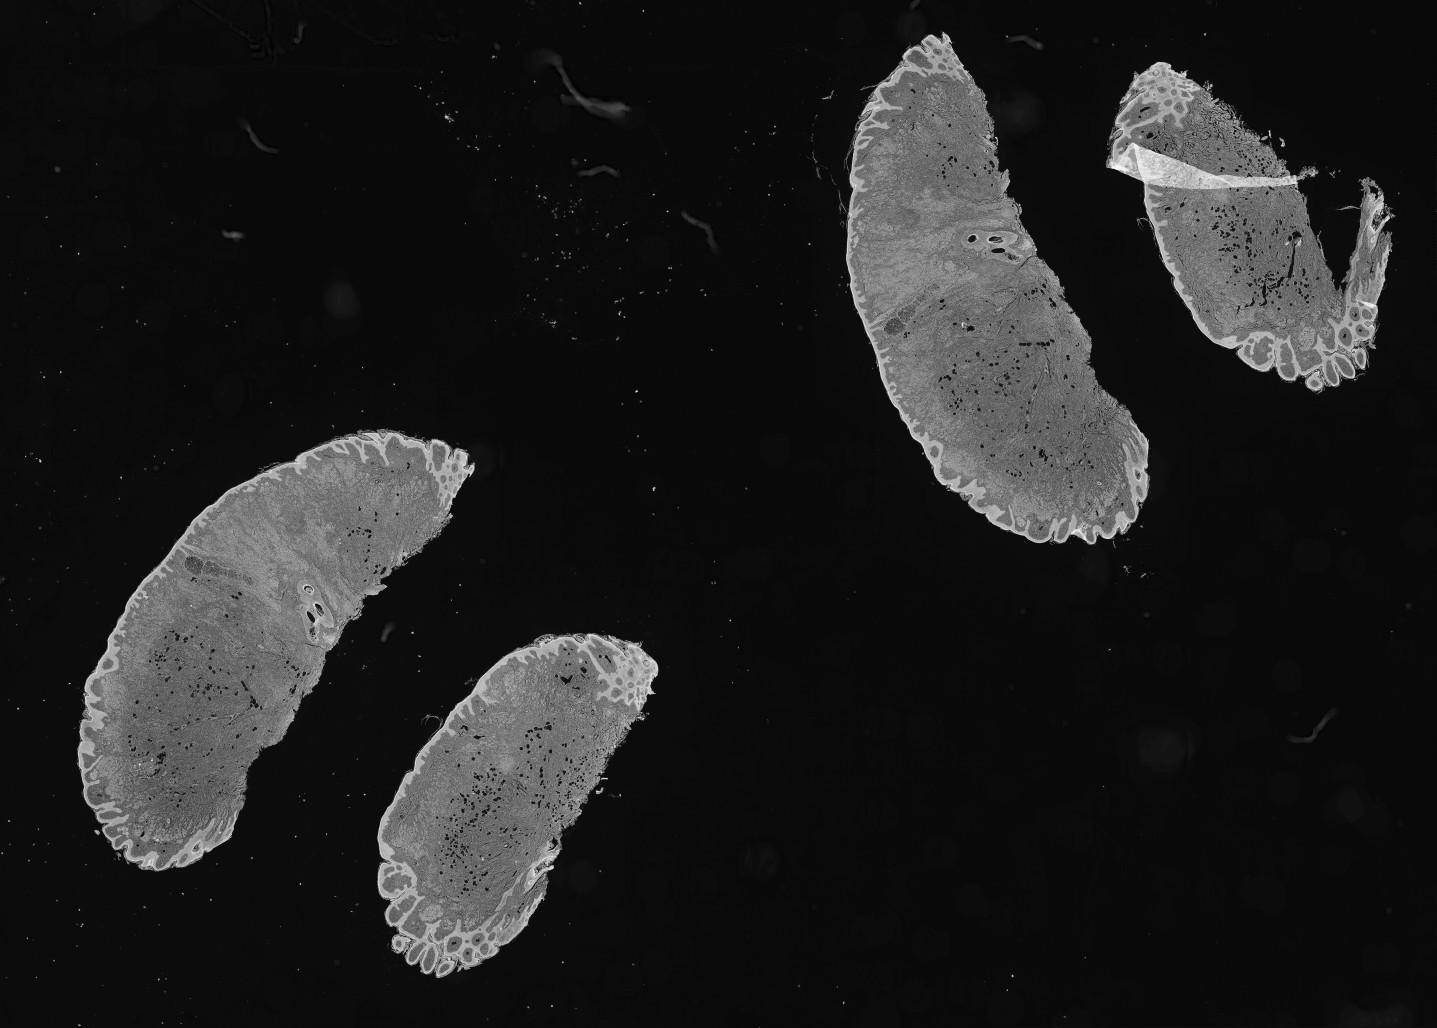

In [21]:
#Contrast stretching on inverted grayscale image
def contrast_stretching(image):
    import numpy as np
    min=np.amin(image)
    max=np.amax(image)
    Contrast_stretched_image=np.zeros((down_scaled_height,down_scaled_width))
    for x in range(down_scaled_height):
        for y in range(down_scaled_width):
            Contrast_stretched_image[x][y]=((image[x][y]-min)/(max-min))*255
    display(Image.fromarray(Contrast_stretched_image.astype(np.uint8)))
    return (Contrast_stretched_image)
contrast_stretched_image=contrast_stretching(inverted_image)

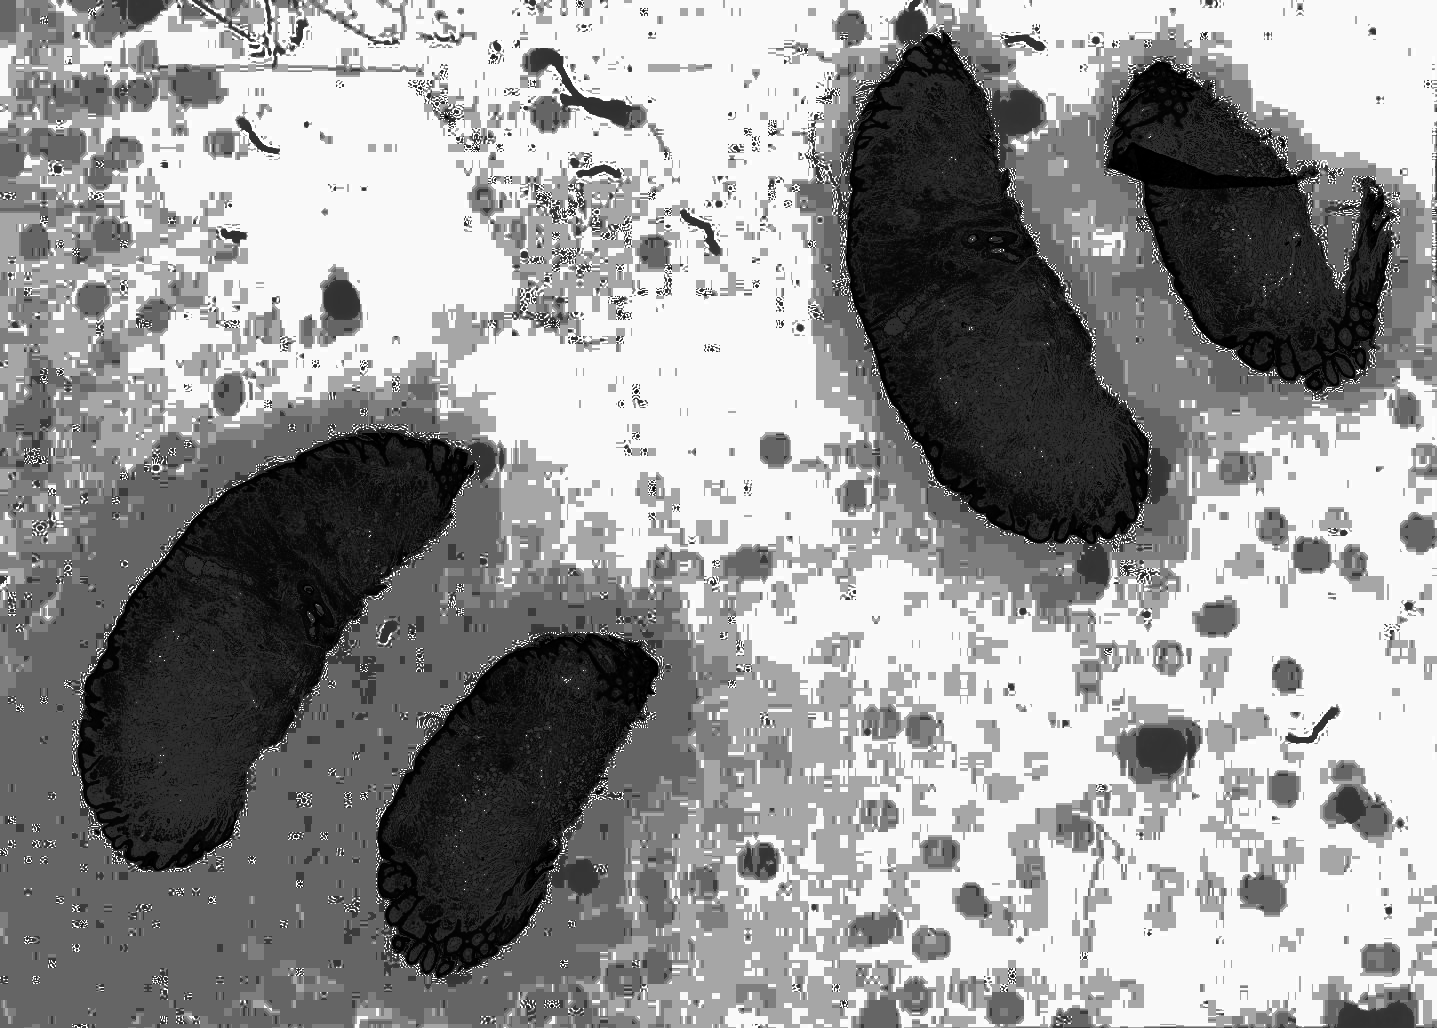

In [22]:
#histogram equalized image of grayscale image
def histogram_equalization(image):
    histogram_equalized=cv2.equalizeHist(image)
    display(Image.fromarray(histogram_equalized))
    return(histogram_equalized)
hist_equalized_image=histogram_equalization(grayscale_image)

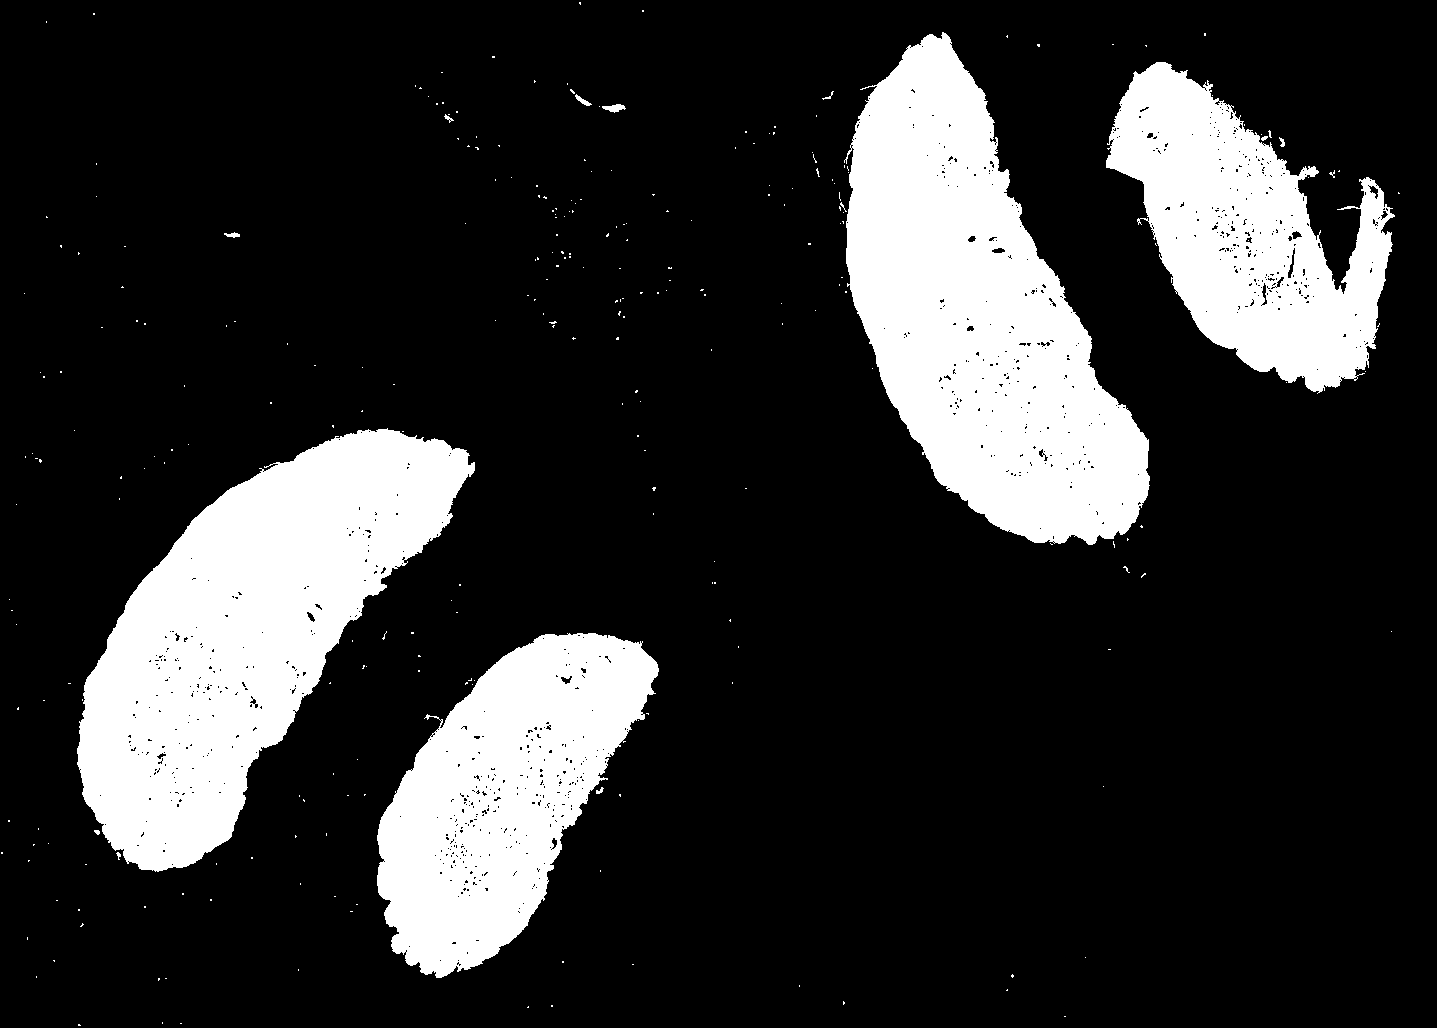

In [23]:
#green channel filter- (excludes pixels with green channel value greaer than 200)
def green_channel_filter(image):
    lowerBound = np.array([0, 0, 0])
    upperBound = np.array([255, 200, 255])
    green_filter_image=cv2.inRange(image, lowerBound, upperBound)
    display(Image.fromarray(green_filter_image))
    return green_filter_image
green_filtered_image=green_channel_filter(img)

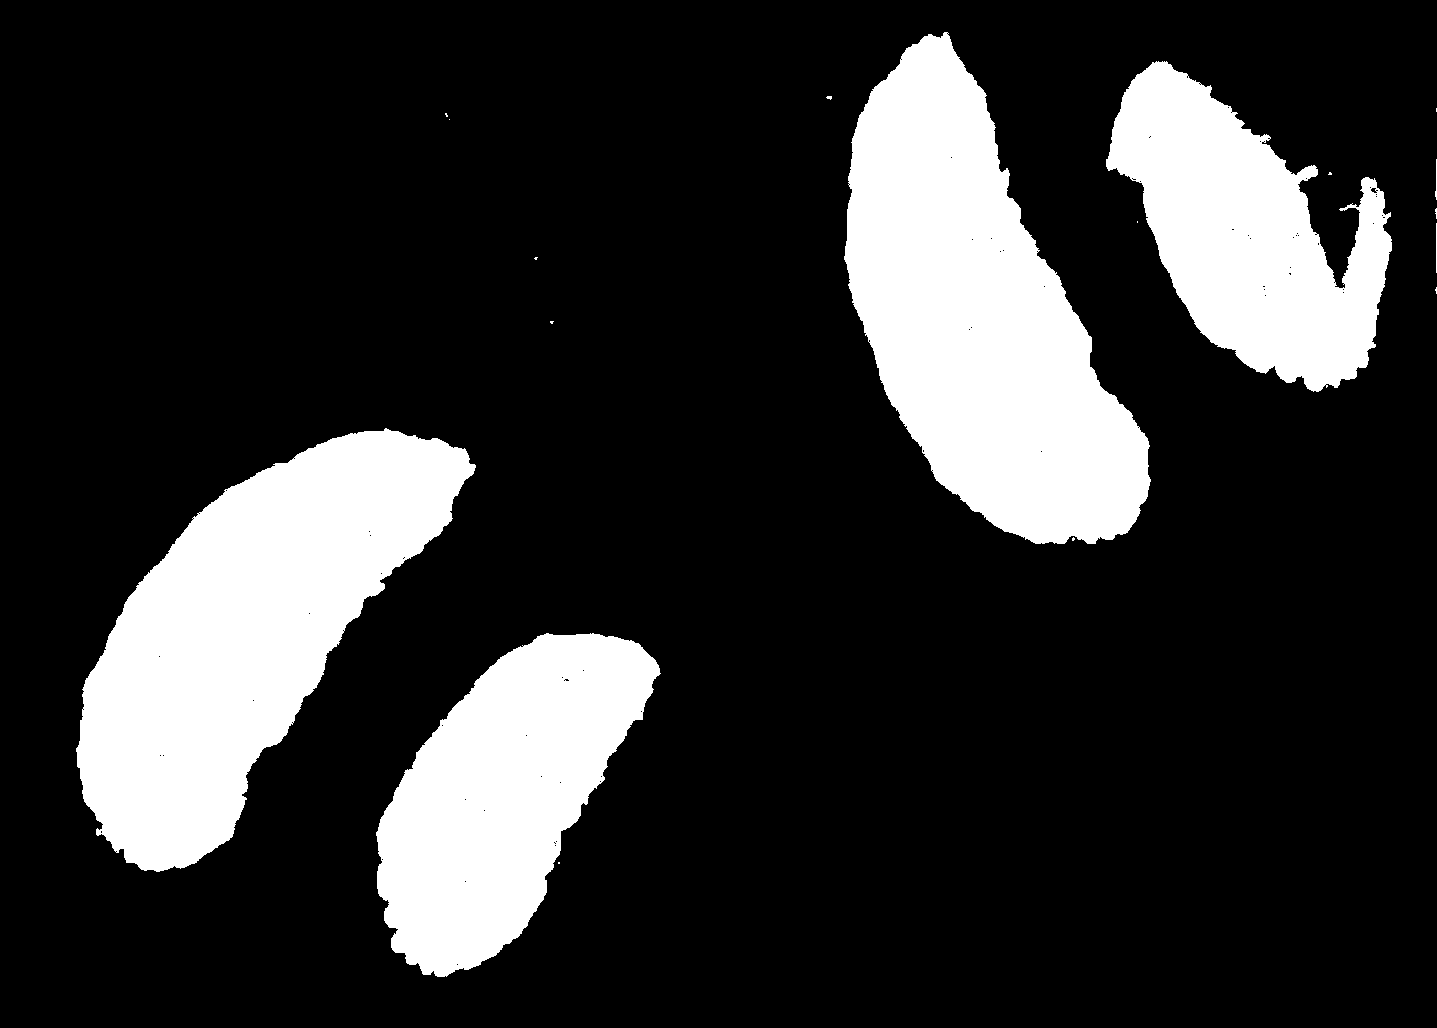

In [24]:
#gray channel filter - (pixels with close r,g,b values are excluded)-(tolerance of 15)
def gray_filter(image):
    gray_filtered_image=np.zeros((down_scaled_height,down_scaled_width))
    for x in range(down_scaled_height):
        for y in range(down_scaled_width):
            if abs(int(image[x,y,0])-int(image[x,y,1]))<15 and abs(int(image[x,y,0])-int(image[x,y,2]))<15 and abs(int(image[x,y,1])-int(image[x,y,2]))<15:
                gray_filtered_image[x][y]=0
            else:
                gray_filtered_image[x][y]=255
    display(Image.fromarray(gray_filtered_image.astype(np.uint8)))
    return (gray_filtered_image)
gray_filtered_image=gray_filter(img)

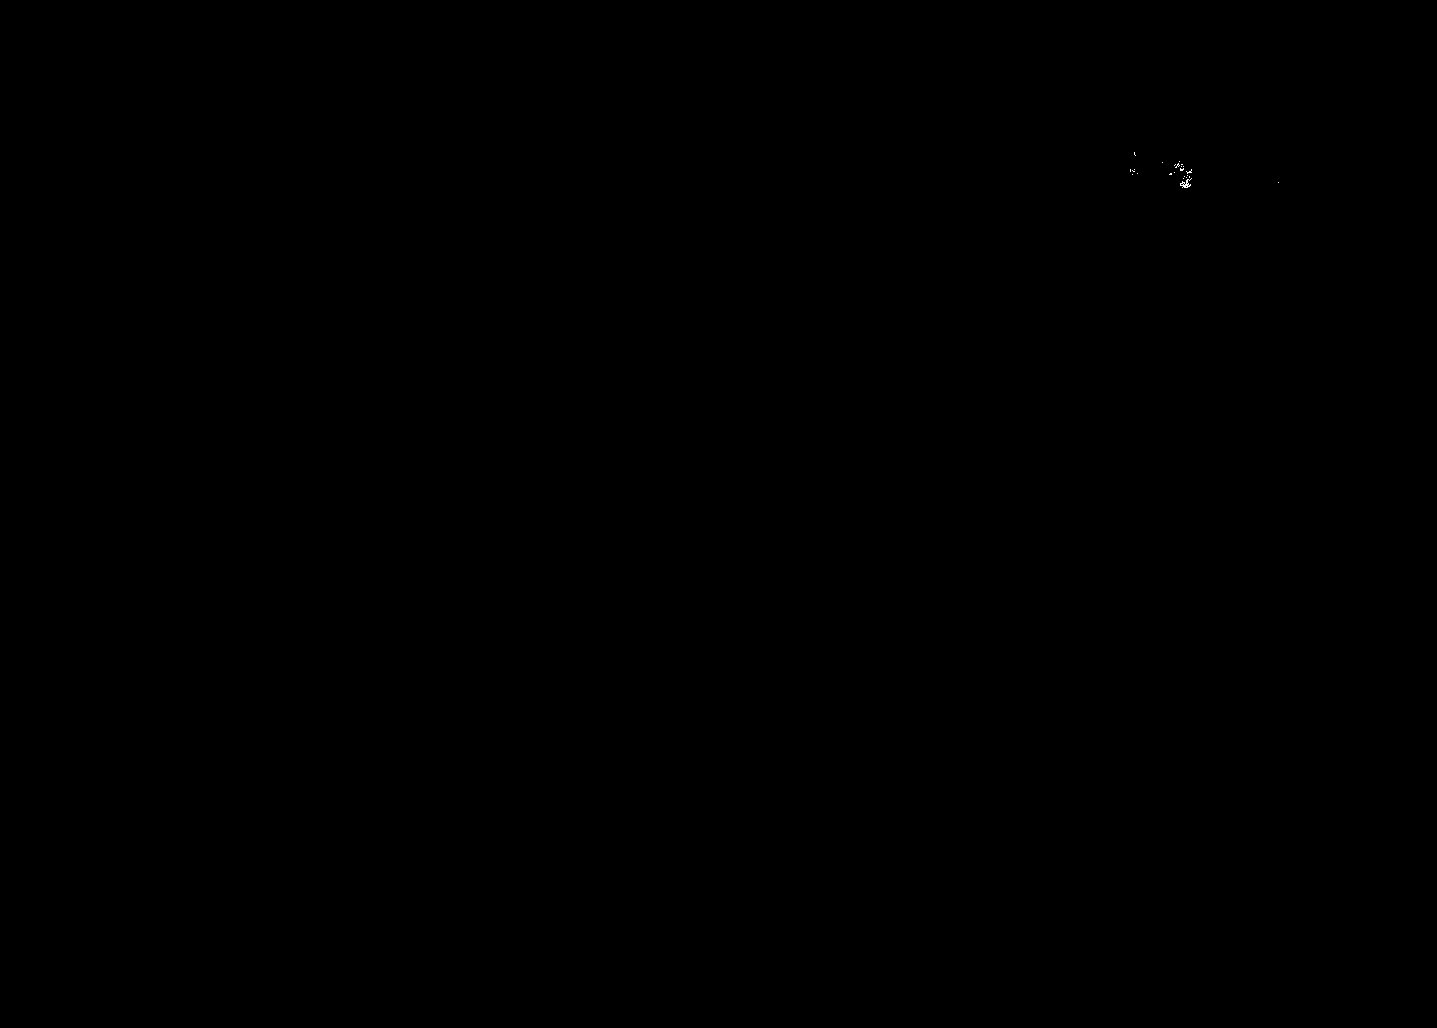

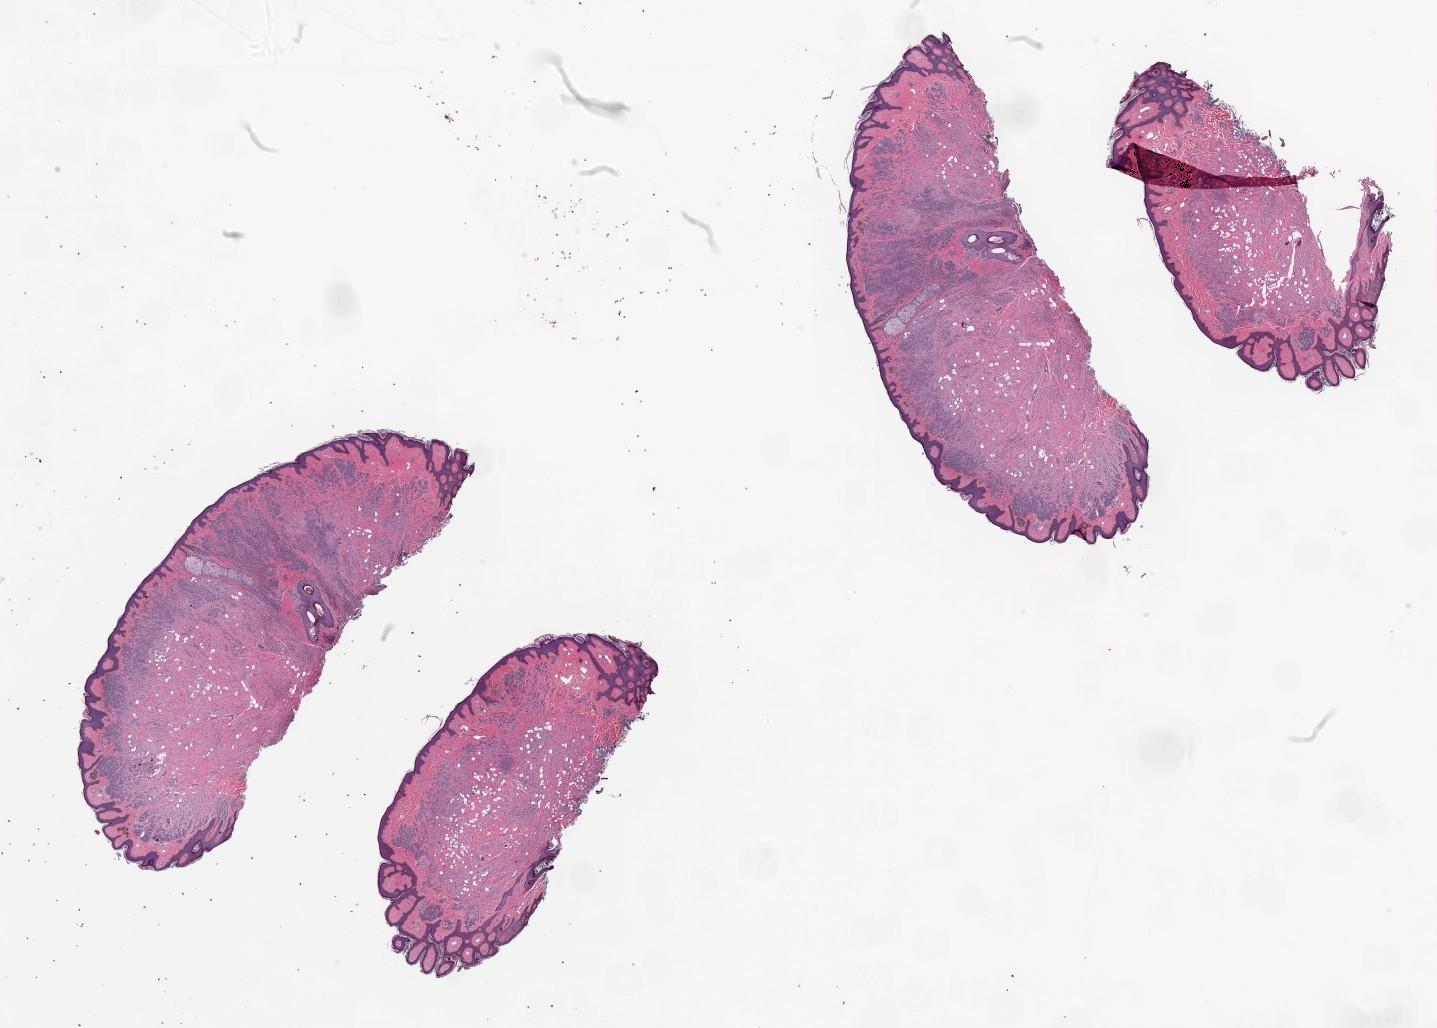

In [25]:
#removes any red pen marks in the slide if present
def red_pen_filter(image):
    lower_red = np.array([150,0,0])
    upper_red = np.array([255,80,90])
    red_pen_filter=cv2.inRange(image, lower_red, upper_red)
    display(Image.fromarray(red_pen_filter))
    red_mask=cv2.cvtColor(cv2.bitwise_not(red_pen_filter),cv2.COLOR_GRAY2BGR)
    red_pen_free_image=cv2.bitwise_and(image,red_mask)
    display(Image.fromarray(red_pen_free_image))
    return red_pen_free_image
ren_pen_filterd_image=red_pen_filter(img)

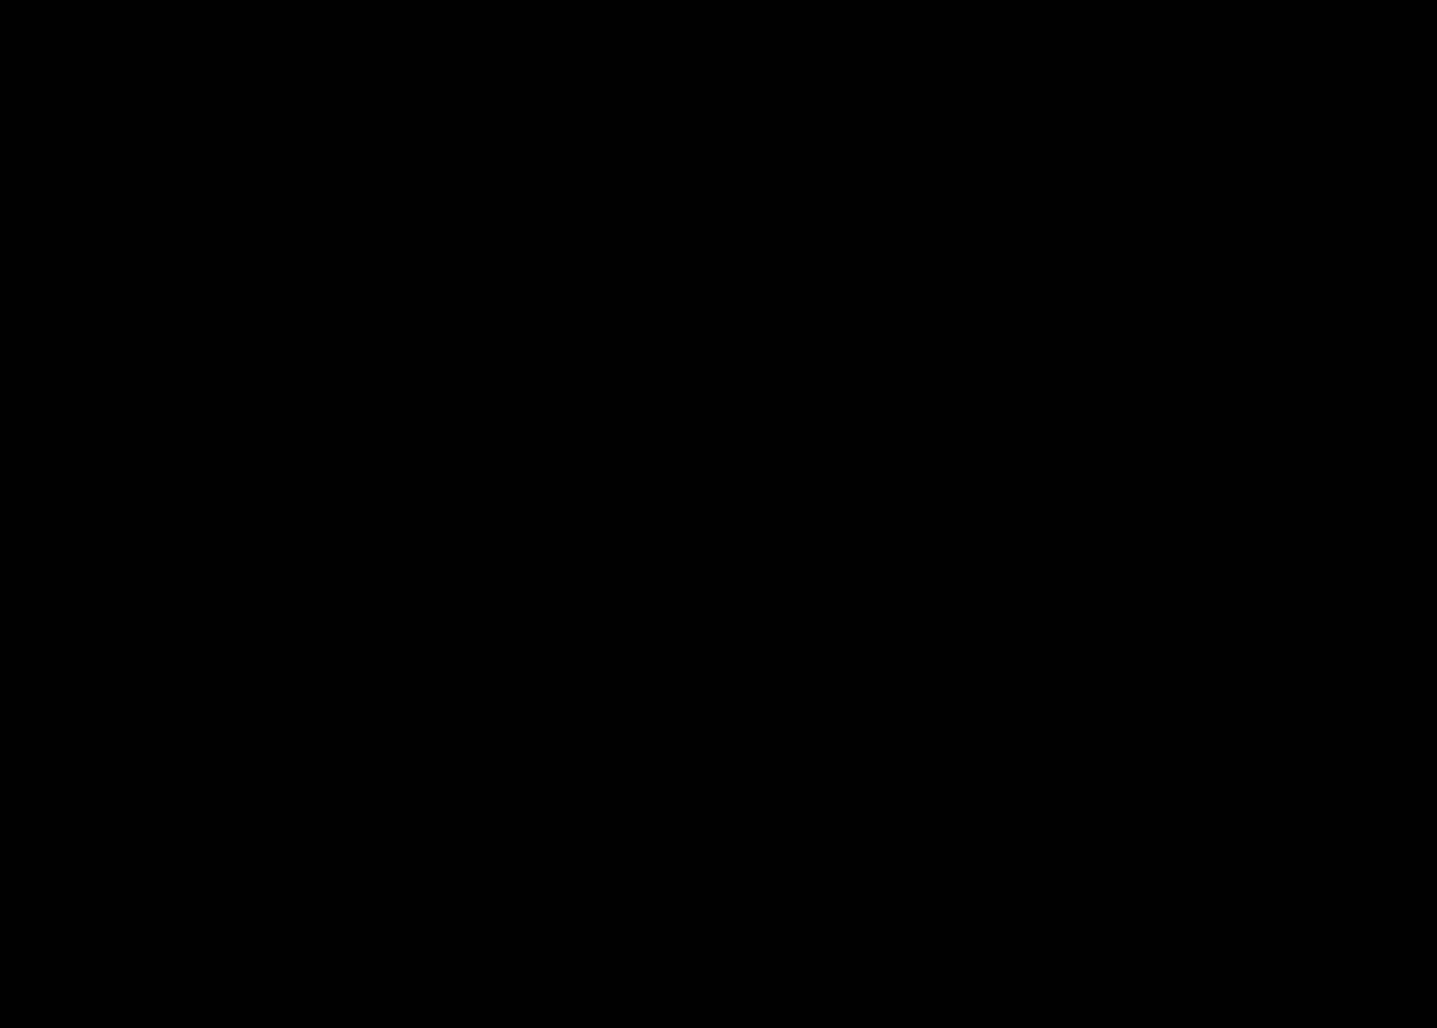

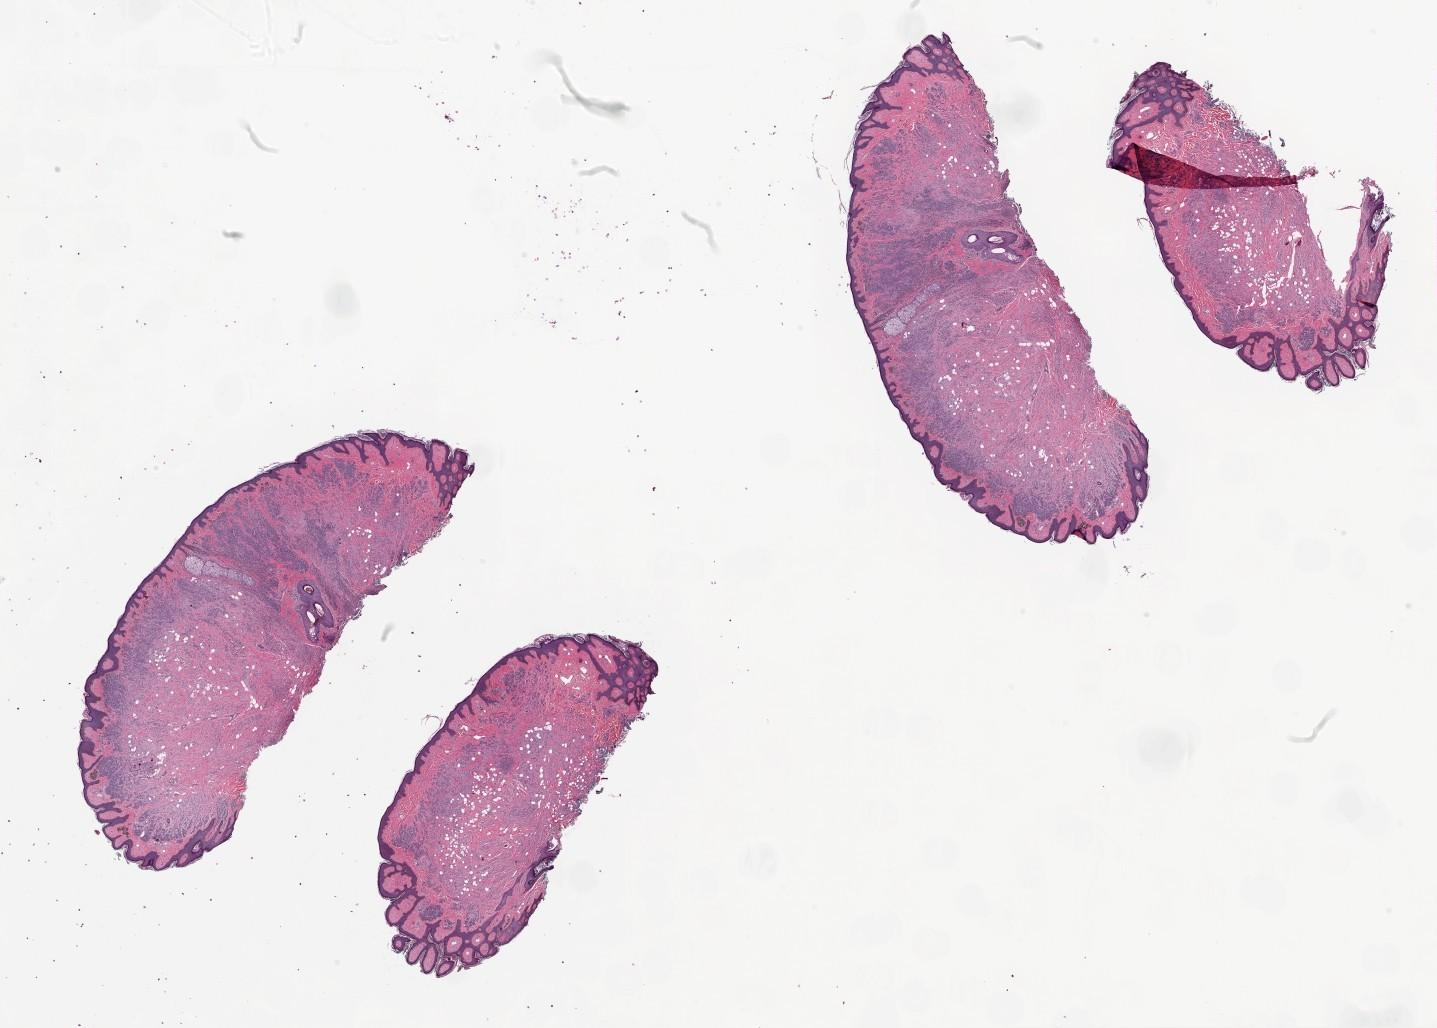

In [26]:
#removes any blue pen marks in the slide if present
def blue_pen_filter(image):
    lower_blue = np.array([0,0,180])
    upper_blue = np.array([130,155,255])
    blue_pen_filter=cv2.inRange(image, lower_blue, upper_blue)
    display(Image.fromarray(blue_pen_filter))
    blue_mask=cv2.cvtColor(cv2.bitwise_not(blue_pen_filter),cv2.COLOR_GRAY2BGR)
    blue_pen_free_image=cv2.bitwise_and(image,blue_mask)
    display(Image.fromarray(blue_pen_free_image))
    return(blue_pen_free_image)
blue_pen_filtered_image=blue_pen_filter(img)

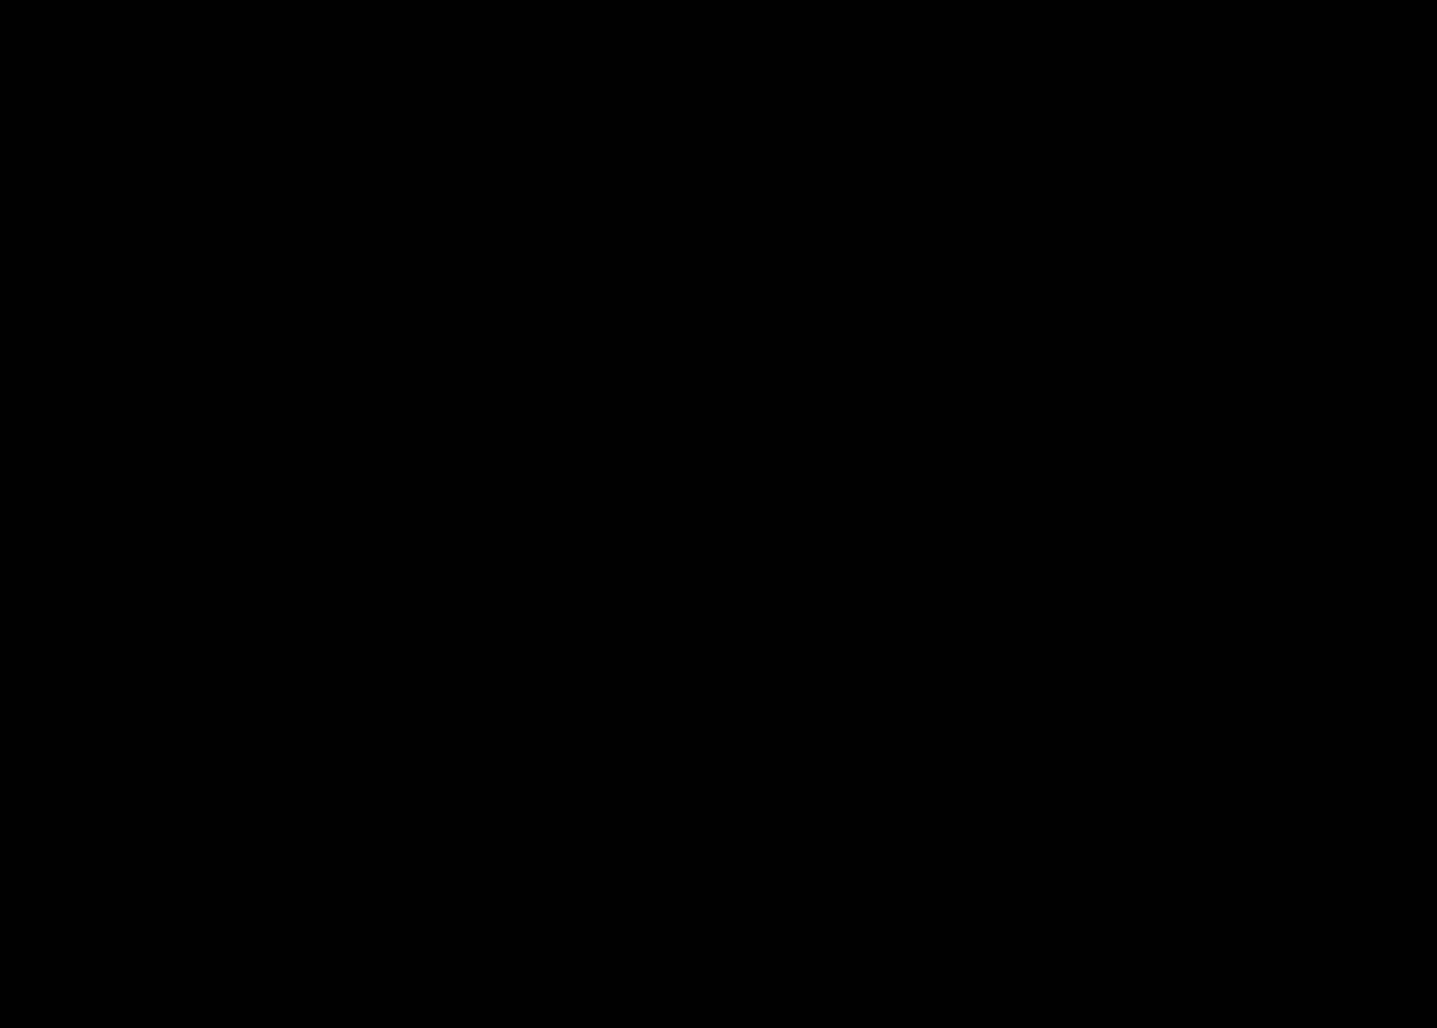

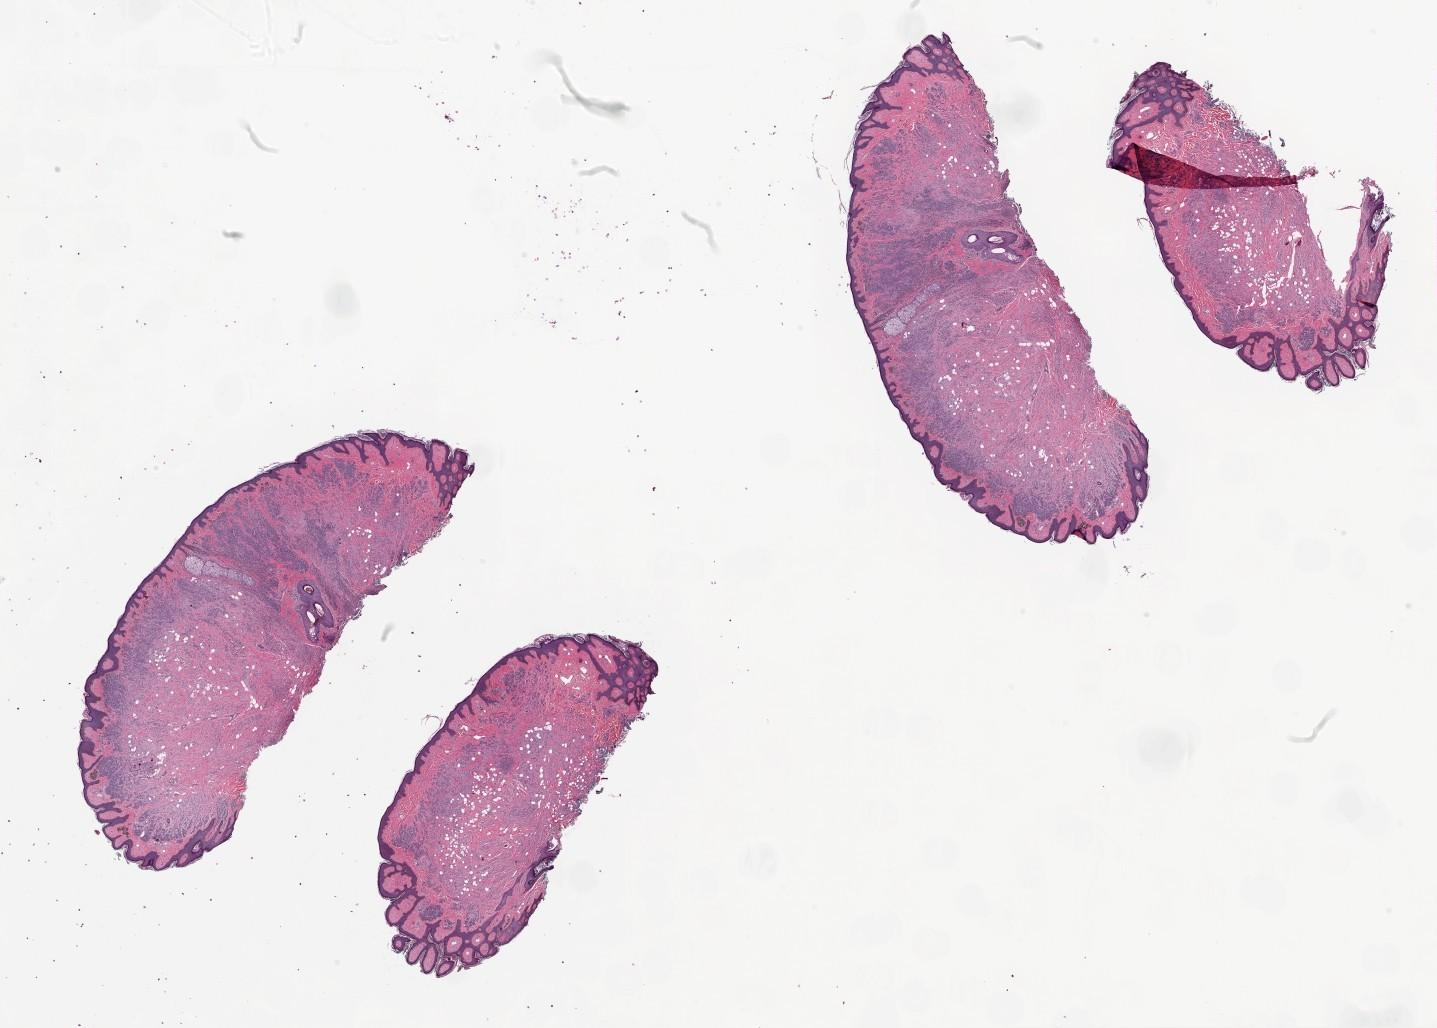

In [27]:
#removes any green pen marks in the slide if present
def green_pen_filter(image):
    lower_green = np.array([0,160,140])
    upper_green = np.array([150,255,255])
    green_pen_filter=cv2.inRange(image, lower_green, upper_green)
    display(Image.fromarray(green_pen_filter))
    green_mask=cv2.cvtColor(cv2.bitwise_not(green_pen_filter),cv2.COLOR_GRAY2BGR)
    green_pen_free_image=cv2.bitwise_and(image,green_mask)
    display(Image.fromarray(green_pen_free_image))
    return green_pen_free_image
green_pen_filtered_image=green_pen_filter(img)

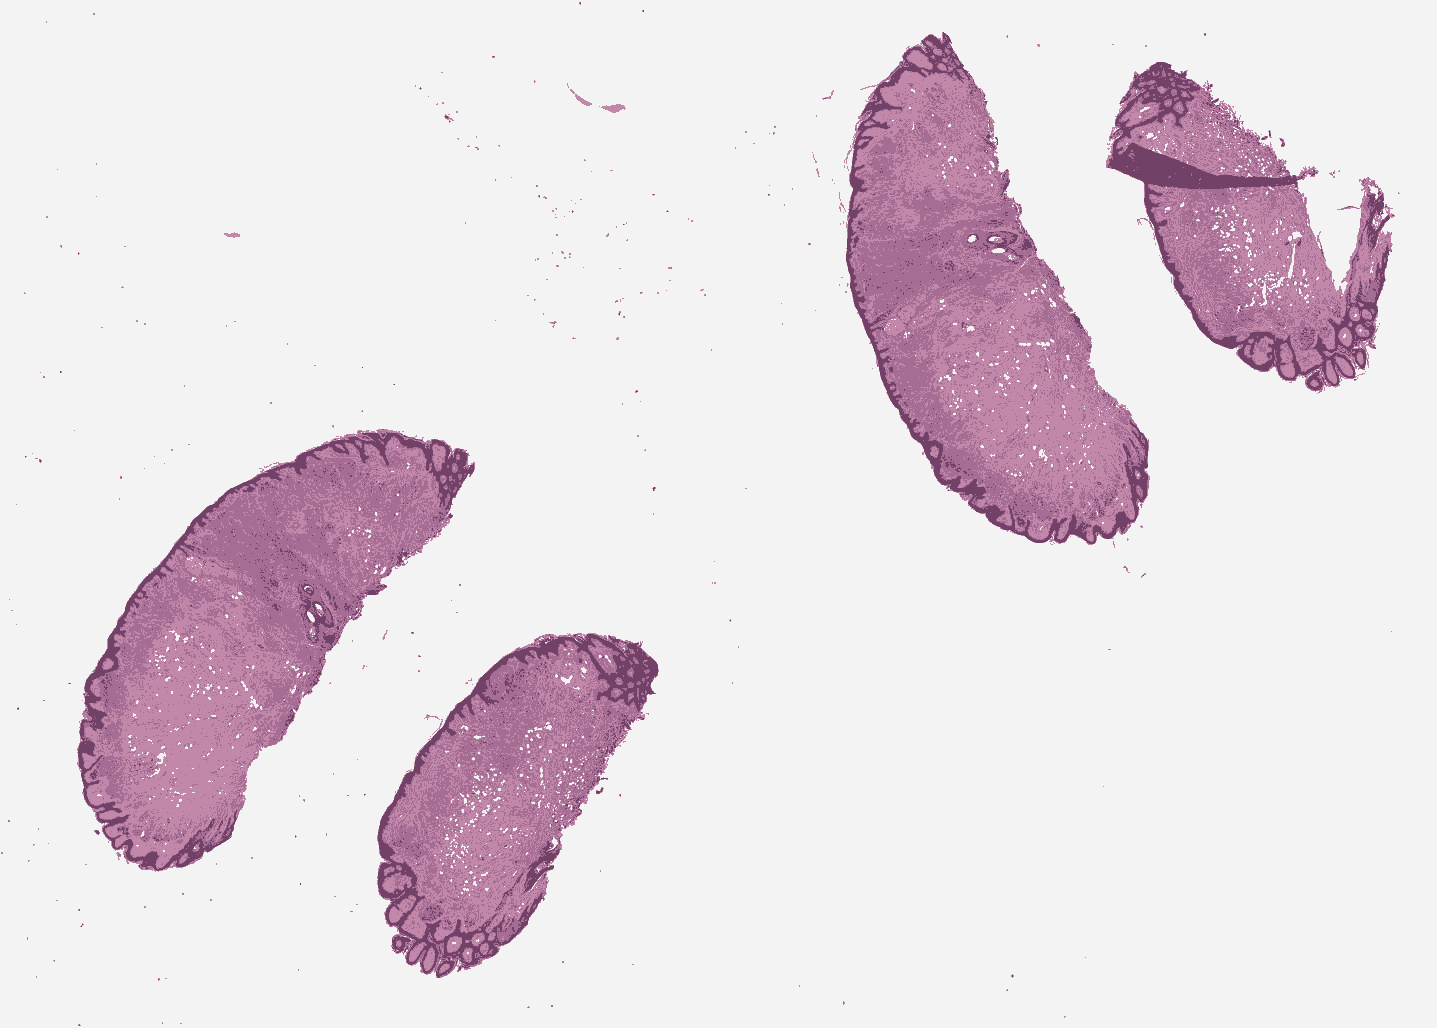

(1028, 1437, 3)


In [55]:
#k-means segmentation
from sklearn.cluster import KMeans
def k_means_seg(image):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, (centers) = cv2.kmeans(pixel_values, 4, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    display(Image.fromarray(segmented_image))
    print(segmented_image.shape)
    return segmented_image
kmeans_segmented_image=k_means_seg(img)

(1028, 1437)


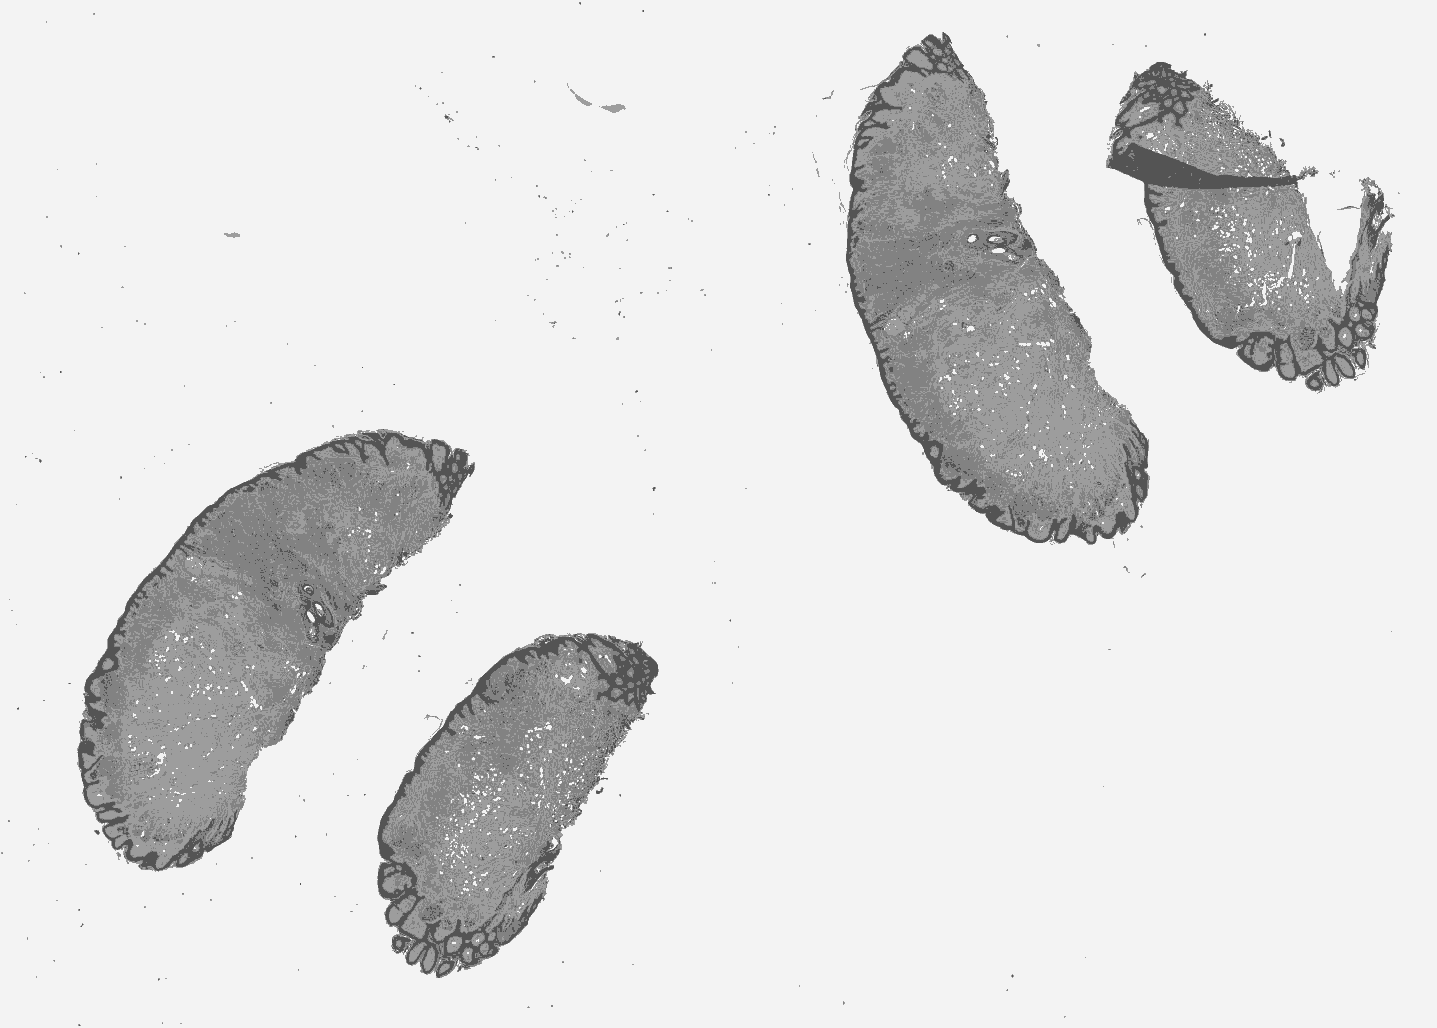

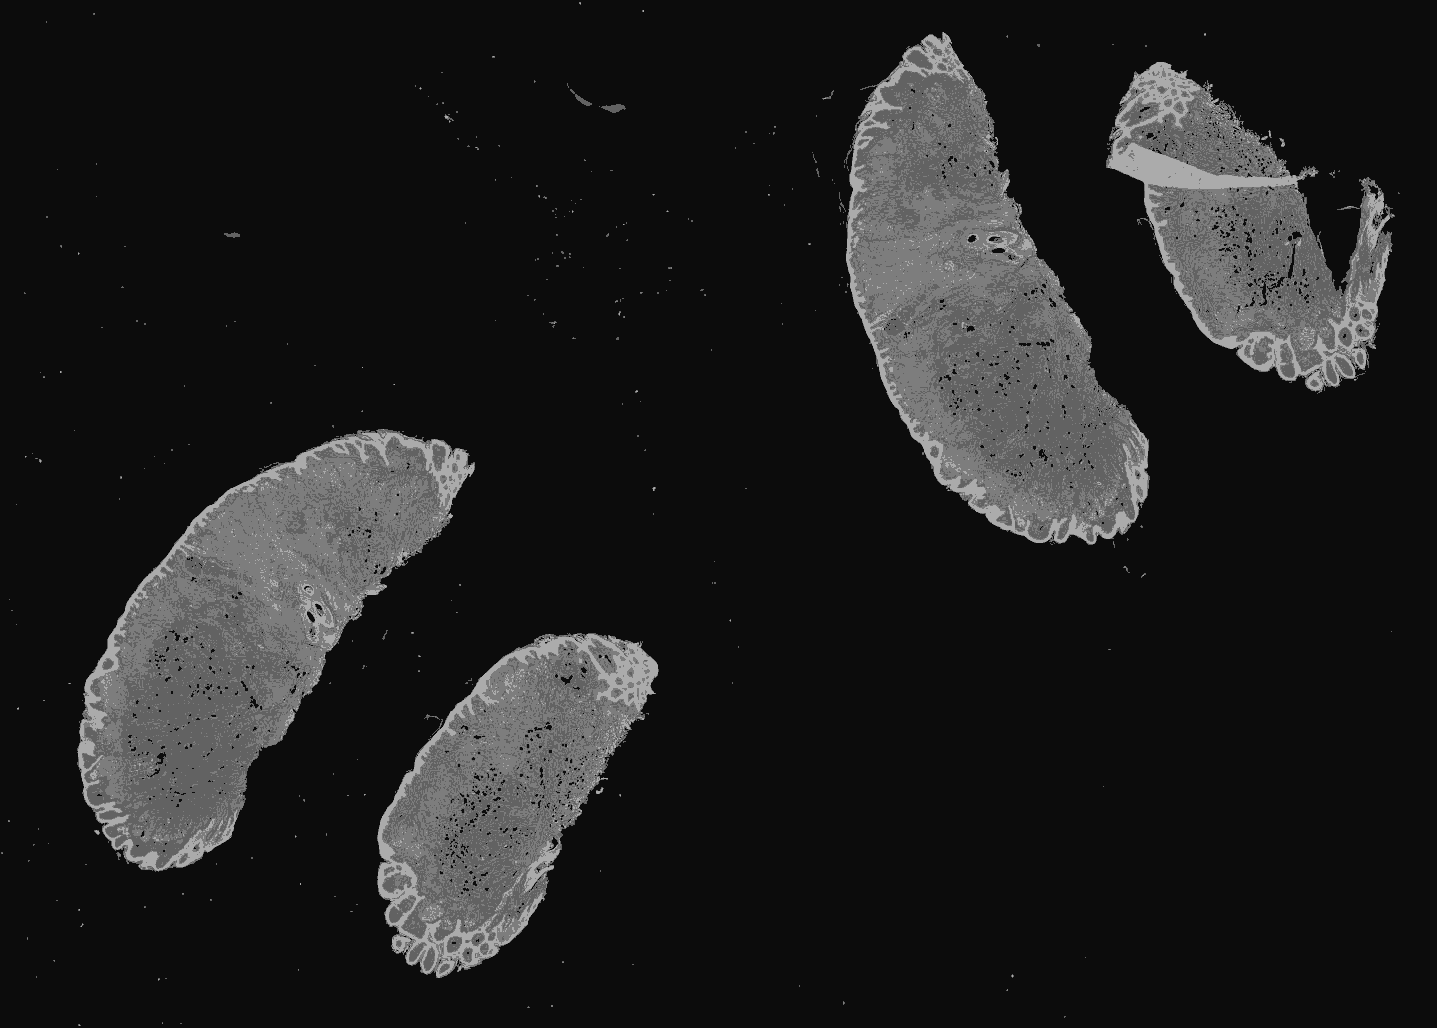

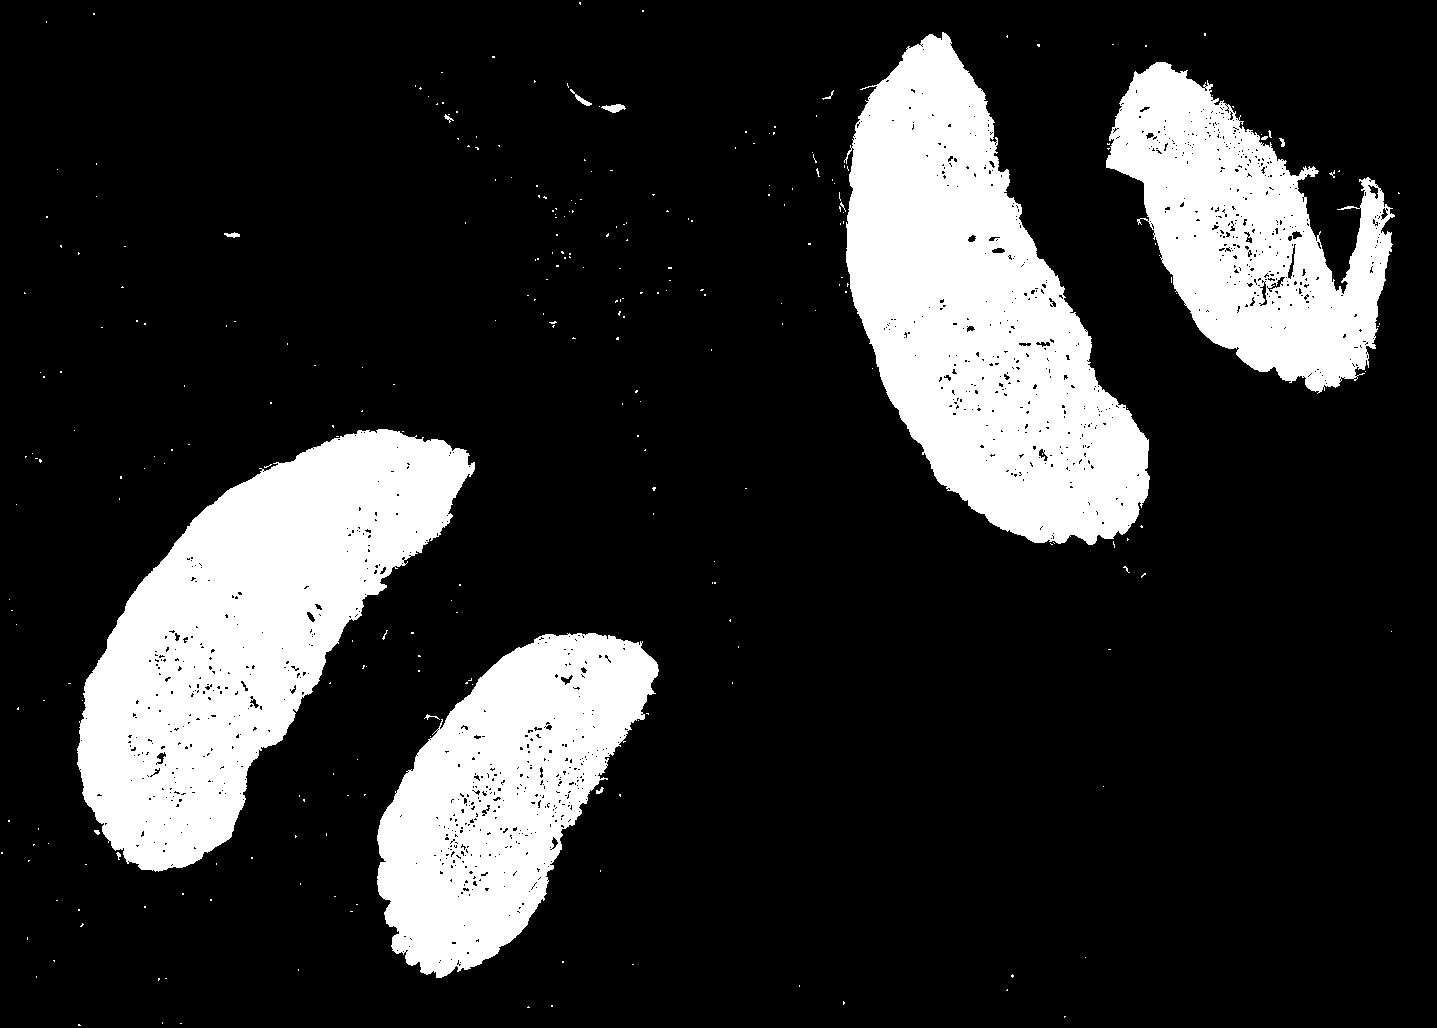

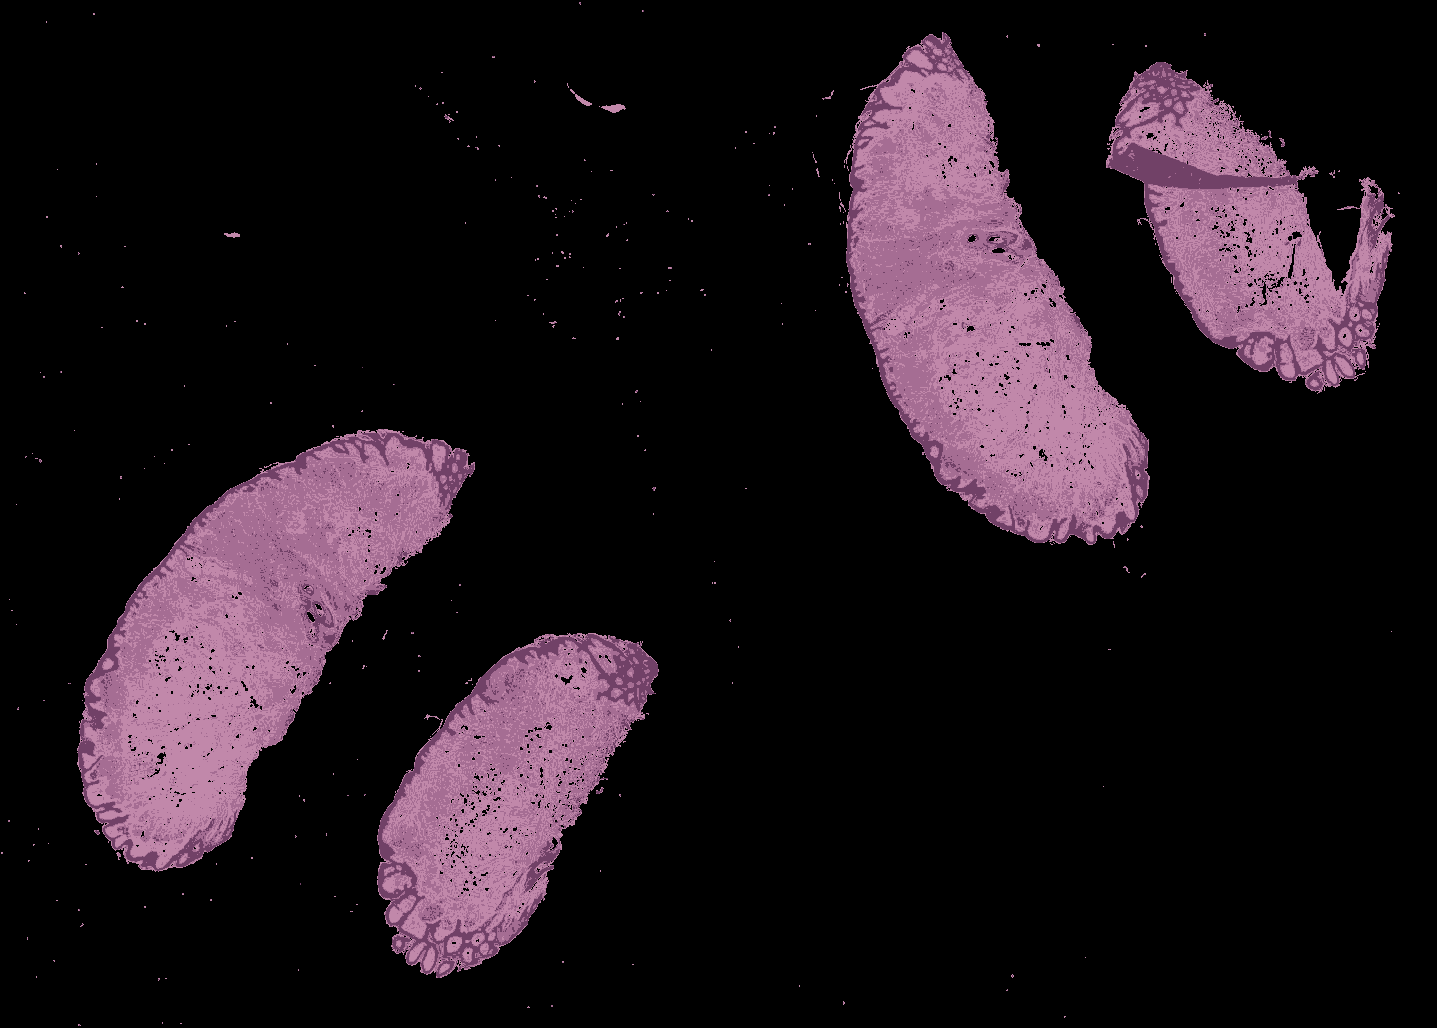

In [63]:
#applying otsu thresholding on the k-means segmented image
grayscale_kmeans=grayscale(kmeans_segmented_image)
inverted_grayscale_kmeans=invert_grayscale(grayscale_kmeans)
otsu_threshold_kmeans_mask=otsu_threshold(inverted_grayscale_kmeans)
cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
kmeans_otsu_thresholded_image=cv2.bitwise_and(kmeans_segmented_image,cv2.cvtColor(otsu_threshold_kmeans_mask, cv2.COLOR_GRAY2RGB))
display(Image.fromarray(kmeans_otsu_thresholded_image))